# Global Flags

In [1]:
use_tiny_dataset = True #about 0:21min per epoch on 100 img set
use_pre_trained = False #pre trained model: 200Epock, 16Batch on YOLOv5l

In [ ]:
#Reading the file
import pandas as pd
import numpy as np
import os

# Image Reading & Preprocessing
from PIL import Image, ImageDraw
import cv2
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np

# Misc.
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier

#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow
%cd ..


import torch
import os
from IPython.display import Image, clear_output  # to display images
import PIL.Image
import shutil

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# In case you need to delete some folders and their content you can use this:

In [38]:
#shutil.rmtree('/content/yolov5/runs/detect/exp2') #delete folder

# Setting up the folder structure 
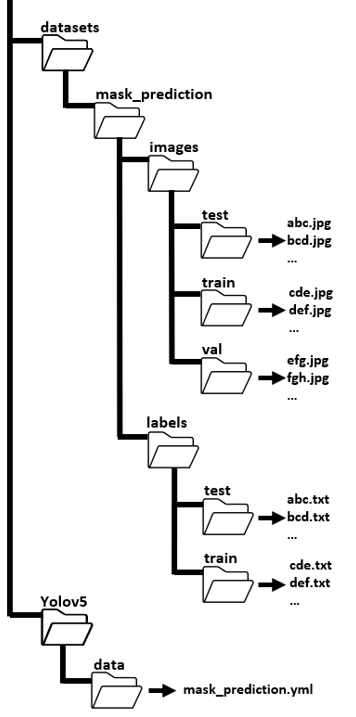

In [4]:
!cd /content/

!rm -rf datasets
!mkdir datasets

%cd datasets
!rm -rf mask_prediction
!mkdir mask_prediction

%cd mask_prediction
!rm -rf images
!mkdir images
!rm -rf labels
!mkdir labels

%cd images
!rm -rf train
!mkdir train
!rm -rf val
!mkdir val
!rm -rf test
!mkdir test

%cd ..
%cd labels
!rm -rf train
!mkdir train
!rm -rf val
!mkdir val
!rm -rf test
!mkdir test

%cd ..
%cd ..
%cd ..


/content/datasets
/content/datasets/mask_prediction
/content/datasets/mask_prediction/images
/content/datasets/mask_prediction
/content/datasets/mask_prediction/labels
/content/datasets/mask_prediction
/content/datasets
/content


# Download Dataset. 
Note: If no longer available you can also find all u need here:
https://github.com/IZMEHD/MaskPrediction

In [6]:
%cd /content
!git clone https://github.com/IZMEHD/MaskPrediction

/content
Cloning into 'MaskPrediction'...
remote: Enumerating objects: 346, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 346 (delta 3), reused 36 (delta 3), pack-reused 310
Receiving objects: 100% (346/346), 662.06 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (22/22), done.


# Unzipping and moving to /datasets/mask_prediction

In [7]:
if(use_tiny_dataset):
  %cd /content/MaskPrediction/TinyDataSets/
  !unzip train.zip -d /content/datasets/mask_prediction/images > /dev/null
  !unzip val.zip -d /content/datasets/mask_prediction/images > /dev/null
  !unzip test.zip -d /content/datasets/mask_prediction/images > /dev/null
  src = "/content/MaskPrediction/TinyDataSets/train.csv"
  dst =  "/content/datasets/mask_prediction/train.csv"
  shutil.copy(src, dst)

  src = "/content/MaskPrediction/TinyDataSets/val.csv"
  dst =  "/content/datasets/mask_prediction/val.csv"
  shutil.copy(src, dst)
else:
  %cd /content/MaskPrediction/
  !7z x "/content/MaskPrediction/Datasets/train/train_.zip.001" -tsplit
  !7z x "/content/MaskPrediction/Datasets/test/test_.zip.001" -tsplit
  !7z x "/content/MaskPrediction/Datasets/val/val_.zip.001" -tsplit
  !unzip train_.zip -d /content/MaskPrediction/ > /dev/null
  !unzip val_.zip -d /content/MaskPrediction/ > /dev/null
  !unzip test_.zip -d /content/MaskPrediction/ > /dev/null
  !unzip train.zip -d /content/datasets/mask_prediction/images > /dev/null
  !unzip val.zip -d /content/datasets/mask_prediction/images > /dev/null
  !unzip test.zip -d /content/datasets/mask_prediction/images > /dev/null
  src = "/content/MaskPrediction/Datasets/train.csv"
  dst =  "/content/datasets/mask_prediction/train.csv"
  shutil.copy(src, dst)

  src = "/content/MaskPrediction/Datasets/val.csv"
  dst =  "/content/datasets/mask_prediction/val.csv"
  shutil.copy(src, dst)
 

/content/MaskPrediction/TinyDataSets


# Now creating the YOLO labels from the CSV file for the training data...

In [8]:
#make yolo labels from csv's for training data
image_size = 512
train_df = pd.read_csv("/content/datasets/mask_prediction/train.csv")

for n in range(len(train_df)):


  #bbox str to int list
  bbox = (train_df.iloc[n].bbox)
  bbox = bbox.replace('[', '')
  bbox = bbox.replace(']', '')
  bbox = bbox.replace(',', '')
  bbox = list(map(int, bbox.split()))


  #get middle(X,Y) and width & height
  X  =(((bbox[2]-bbox[0])/2) /image_size)+bbox[0]/image_size
  Y  =  (((bbox[3]-bbox[1])/2) /image_size) +bbox[1]/image_size
  width = ((bbox[2]-bbox[0])) /image_size
  height =((bbox[3]-bbox[1])) /image_size


  #get mask type as int
  if(train_df.iloc[n].masktype == "surgical"):#surgical = 0 
    mask_class =  0
  elif(train_df.iloc[n].masktype == "N95"):#N95 = 1
    mask_class =  1
  elif(train_df.iloc[n].masktype == "KN95"):#KN95 = 2
    mask_class =  2
  elif(train_df.iloc[n].masktype == "cloth"):#cloth = 3
    mask_class =  3
  else:
    print("unknown mask type!!!")#let's hope this does not happen


  #plot boundingBox
  if(False):#debug stuff
    print(mask_class , X ,Y ,width ,height)
    data = image.imread(train_images +  str(train_df.iloc[n].ImageID) + ".jpg")
    plt.plot(X*image_size, Y*image_size, marker='*', color="r")
    plt.plot([bbox[0],bbox[0]], [bbox[1],bbox[3]],c = 'r')
    plt.plot([bbox[0],bbox[2]], [bbox[3],bbox[3]],c = 'r')
    plt.plot([bbox[2],bbox[2]], [bbox[1],bbox[3]],c = 'r')
    plt.plot([bbox[0],bbox[2]], [bbox[1],bbox[1]],c = 'r')
    plt.imshow(data)  
    plt.show()


  #write txt for YOLO lable
  f= open('/content/datasets/mask_prediction/labels/train/' +  str(train_df.iloc[n].ImageID) + ".txt","w+")
  YOLO_string = str(mask_class) +" "+ str(X) +" "+ str(Y) +" "+ str(width) + "  " + str(height)
  #print("YOLO_string:", YOLO_string)
  f.write( YOLO_string )
  f.close()

# ...and creating the YOLO labels from the CSV file for the val data

In [9]:
#make yolo labels from csv's for val data
image_size = 512
train_df = pd.read_csv("/content/datasets/mask_prediction/val.csv")
for n in range(len(train_df)):

  #bbox str to int list
  bbox = (train_df.iloc[n].bbox)
  bbox = bbox.replace('[', '')
  bbox = bbox.replace(']', '')
  bbox = bbox.replace(',', '')
  bbox = list(map(int, bbox.split()))


  #get middle(X,Y) and width & height  // xmin,ymin, xmax ,ymax
  X  =(((bbox[2]-bbox[0])/2) /image_size)+bbox[0]/image_size
  Y  =  (((bbox[3]-bbox[1])/2) /image_size) +bbox[1]/image_size
  width = ((bbox[2]-bbox[0])) /image_size
  height =((bbox[3]-bbox[1])) /image_size


  #get mask type as int
  if(train_df.iloc[n].masktype == "surgical"):#surgical = 0 
    mask_class =  0
  elif(train_df.iloc[n].masktype == "N95"):#N95 = 1
    mask_class =  1
  elif(train_df.iloc[n].masktype == "KN95"):#KN95 = 2
    mask_class =  2
  elif(train_df.iloc[n].masktype == "cloth"):#cloth = 3
    mask_class =  3
  else:
    print("unknown mask type!!!")#let's hope this does not happen


  #plot boundingBox
  if(False):#debug stuff
    print(mask_class , X ,Y ,width ,height)
    data = image.imread(train_images +  str(train_df.iloc[n].ImageID) + ".jpg")
    plt.plot(X*image_size, Y*image_size, marker='*', color="r")
    plt.plot([bbox[0],bbox[0]], [bbox[1],bbox[3]],c = 'r')
    plt.plot([bbox[0],bbox[2]], [bbox[3],bbox[3]],c = 'r')
    plt.plot([bbox[2],bbox[2]], [bbox[1],bbox[3]],c = 'r')
    plt.plot([bbox[0],bbox[2]], [bbox[1],bbox[1]],c = 'r')
    plt.imshow(data)  
    plt.show()


  #write txt for YOLO lable
  f= open('/content/datasets/mask_prediction/labels/val/' +  str(train_df.iloc[n].ImageID) + ".txt","w+") # 
  YOLO_string = str(mask_class) +" "+ str(X) +" "+ str(Y) +" "+ str(width) + "  " + str(height)
  f.write( YOLO_string )
  f.close()

# Let's see if the graphics card is there.. should look something like this:
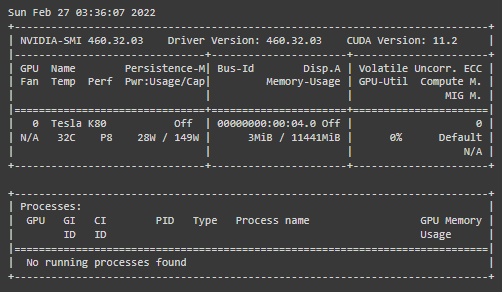

In [10]:
!nvidia-smi

Mon Feb 28 16:55:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    35W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Tensorboard  (optional)
%load_ext tensorboard
%tensorboard --logdir runs/train

In [ ]:
# Weights & Biases  (optional)
%pip install -q wandb
import wandb
wandb.login()

# Make a "mask_prediction.yml" in "yolov5/data" 


In [11]:
mask_prediction_string = "train: /content/datasets/mask_prediction/images/train" + '\n'
mask_prediction_string +=  "val: /content/datasets/mask_prediction/images/val" + '\n'
mask_prediction_string +=  "nc: 4" + '\n'
mask_prediction_string +=  "names: [‘surgical’, ‘N95’,‘KN95’, ‘cloth’]" + '\n'

file1 = open("/content/yolov5/data/mask_prediction.yml","w")
file1.writelines(mask_prediction_string)
file1.close() 

# Training

In [12]:
%cd /content/yolov5
if(use_pre_trained):
  !python train.py --img 512 --batch 16 --epochs 10 --data ./data/mask_prediction.yml --weights /content/MaskPrediction/pretrained_weights/200Epoch_16Batch_YOLOv5l.pt
else:
  !python train.py --img 512 --batch 16 --epochs 10 --data ./data/mask_prediction.yml --weights /weights/yolov5l.pt


/content/yolov5
train: weights=/weights/yolov5l.pt, cfg=, data=./data/mask_prediction.yml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-11-g63ddb6f torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.

# First inference with low confidence threshold

In [13]:
!python detect.py --source /content/datasets/mask_prediction/images/test/ --weights /content/yolov5/runs/train/exp/weights/last.pt  --save-txt --conf 0.01 


detect: weights=['/content/yolov5/runs/train/exp/weights/last.pt'], source=/content/datasets/mask_prediction/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.01, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-11-g63ddb6f torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 367 layers, 46124433 parameters, 0 gradients, 107.8 GFLOPs
image 1/100 /content/datasets/mask_prediction/images/test/00t87.jpg: 640x640 3 ‘surgical’s, 2 ‘N95’s, 3 ‘KN95’s, 6 ‘cloth’s, Done. (0.115s)
image 2/100 /content/datasets/mask_prediction/images/test/0nmuq.jpg: 640x640 8 ‘surgical’s, 2 ‘N95’s, 6 ‘KN95’s, 3 ‘cloth’s, Done. (0.117s)
image 3/100 /content/datasets/mask_prediction/imag

# Second inference with default confidence threshold


In [14]:
!python detect.py --source /content/datasets/mask_prediction/images/test/ --weights /content/yolov5/runs/train/exp/weights/last.pt  --save-txt

detect: weights=['/content/yolov5/runs/train/exp/weights/last.pt'], source=/content/datasets/mask_prediction/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-11-g63ddb6f torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 367 layers, 46124433 parameters, 0 gradients, 107.8 GFLOPs
image 1/100 /content/datasets/mask_prediction/images/test/00t87.jpg: 640x640 Done. (0.152s)
image 2/100 /content/datasets/mask_prediction/images/test/0nmuq.jpg: 640x640 Done. (0.138s)
image 3/100 /content/datasets/mask_prediction/images/test/17d0l.jpg: 640x640 Done. (0.128s)
image 4/100 /content/datasets/mask_prediction/images/t

# See in how many images of mask was detected with low confidence threshold

In [15]:
allfiles = os.listdir('/content/yolov5/runs/detect/exp/labels')
print(len(allfiles))

100


# # See in how many images of mask was detected with default confidence threshold

In [16]:
allfiles = os.listdir('/content/yolov5/runs/detect/exp2/labels')
print(len(allfiles))

16


# Move all images that got detected with the default confidence threshold to the one with low confidence threshold. 

In [17]:
src = '/content/yolov5/runs/detect/exp2/labels/'
dest ='/content/yolov5/runs/detect/exp/labels/'
 
files = os.listdir(src)
 
for f in files:
    os.replace(src + f, dest + f)
allfiles = os.listdir('/content/yolov5/runs/detect/exp/labels')
print(len(allfiles))

100


# create a CSV file from the labels

In [34]:


path_to_found_labels = "/content/yolov5/runs/detect/exp/labels/" # !!! adjust this for your file-structure  !!!

mask_types = ["surgical" ,"N95", "KN95", "cloth"]

sample_submission = pd.read_csv("/content/MaskPrediction/TinyDataSets/test.csv")
submission = 'ImageID,bbox,masktype\n'

for i in range(len(sample_submission)):
#for i in range(2):
  image_name = sample_submission.iloc[i].ImageID
  
  label_path = path_to_found_labels + image_name + ".txt"



  try:
    f = open(  label_path, "r")
    values = f.read()
    print(image_name,"  ", values)
    values_indiv = list(map(float, values.split()))
    print(values_indiv[0])
    f.close()
  except:
    label_path = path_to_found_labels + sample_submission.iloc[0].ImageID + ".txt"
    f = open(  label_path, "r")
    values = f.read()
    print(image_name,"  ", values)
    values_indiv = list(map(float, values.split()))
    print(values_indiv[0])
    f.close()


  masktype = mask_types[int(values_indiv[0])]
  X_start =str( int(    (values_indiv[1] - (values_indiv[3]/2)) *512      )        )
  Y_start =str( int(    (values_indiv[2] - (values_indiv[4]/2)) *512      )        )
  X_end =str( int(    (values_indiv[1] + (values_indiv[3]/2)) *512      )        )
  y_end =str( int(    (values_indiv[2] + (values_indiv[4]/2)) *512      )        )
  
  submission = submission + image_name + "," + '"[' + X_start +   "," + Y_start  +   "," + X_end  +   "," + y_end   + ']"' +   "," +masktype + '\n'

f = open("/content/submission.csv", "a")
f.write(submission)
f.close()

 



5fo87    3 0.211914 0.518555 0.216797 0.529297
3 0.0654297 0.663086 0.130859 0.486328
3 0.0576172 0.418945 0.115234 0.396484
0 0.223633 0.711914 0.251953 0.263672
0 0.324219 0.21875 0.21875 0.222656
3 0.162109 0.249023 0.230469 0.498047
0 0.174805 0.220703 0.251953 0.21875
3 0.259766 0.672852 0.132812 0.509766
3 0.0478516 0.714844 0.0957031 0.433594
3 0.310547 0.532227 0.246094 0.412109
1 0.5 0.49707 1 0.994141
3 0.110352 0.308594 0.185547 0.570312
3 0.256836 0.261719 0.240234 0.46875
3 0.210938 0.664062 0.121094 0.554688
3 0.158203 0.664062 0.15625 0.515625

3.0
l8ekz    0 0.533203 0.488281 0.644531 0.210938

0.0
834kx    0 0.828125 0.21875 0.199219 0.125
2 0.5 0.322266 1 0.644531
3 0.923828 0.129883 0.152344 0.259766
3 0.270508 0.462891 0.408203 0.300781
1 0.605469 0.422852 0.789062 0.845703

0.0
ophla    2 0.763672 0.208008 0.472656 0.416016
2 0.867188 0.245117 0.175781 0.154297
2 0.592773 0.214844 0.154297 0.429688
1 0.324219 0.371094 0.648438 0.742188
1 0.637695 0.443359 0.724609 

# **done** 